# Intro a Qiskit

In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, ClassicalRegister

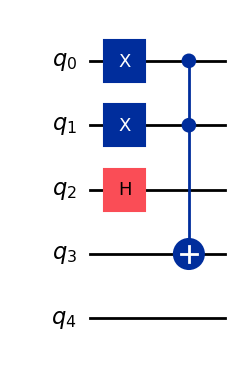

In [3]:
qc = QuantumCircuit(5)
qc.x(range(2))
qc.ccx(0, 1, target_qubit= 3)
qc.h(2)
qc.draw('mpl')



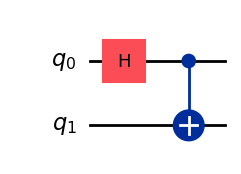

In [4]:
from qiskit.quantum_info import Statevector, DensityMatrix

qc = QuantumCircuit(2)

qc.h(0)
qc.cx(0, 1)

qc.draw('mpl')

In [5]:
DensityMatrix(qc).draw('latex')

<IPython.core.display.Latex object>

In [6]:
from qiskit_nature.second_q.drivers import PySCFDriver

driver = PySCFDriver(atom= 'H 0 0 0 ; H 0 0 0.7')

problema = driver.run()


fermionic_op = problema.hamiltonian.second_q_op()

$$\hat{H} = \sum_{ij} h_{ij} a^{\dagger}_i a_j + \cdots$$

In [7]:
from qiskit_nature.second_q.mappers import  JordanWignerMapper


mapper = JordanWignerMapper()

sparse_pauli_ham = mapper.map(fermionic_op)

sparse_pauli_ham


SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.79804642+0.j,  0.17771287+0.j, -0.24274281+0.j,  0.17771287+0.j,
 -0.24274281+0.j,  0.12293305+0.j,  0.17059738+0.j,  0.16768319+0.j,
  0.04475014+0.j,  0.04475014+0.j,  0.04475014+0.j,  0.04475014+0.j,
  0.16768319+0.j,  0.17627641+0.j,  0.12293305+0.j])

In [8]:
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

init_state = HartreeFock(num_spatial_orbitals= problema.num_spatial_orbitals,
            num_particles= problema.num_particles,
            qubit_mapper= mapper)

#init_state.draw('mpl')


ansatz = UCCSD(
    2,
    problema.num_particles,
    mapper,
    initial_state=HartreeFock(
        problema.num_spatial_orbitals,
        problema.num_particles,
        mapper,
    ),
)

#ansatz.decompose(reps=4).draw('mpl')

In [9]:
import numpy as np
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator



vqe = VQE(Estimator(), ansatz, SLSQP())

from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint


initial_point = HFInitialPoint()
initial_point.ansatz = ansatz
initial_point.problem = problema
vqe.initial_point = initial_point.to_numpy_array()


In [10]:
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
solver = GroundStateEigensolver(mapper, vqe)
result = solver.solve(problema)

print(f"Total ground state energy = {result.total_energies[0]:.4f}")

Total ground state energy = -1.1362


In [11]:
distances = np.arange(0.5, 1, 0.01)

energies = np.zeros(len(distances))

#from qiskit_aer import AerSimulator
#from qiskit_aer.primitives import Estimator as AerEstimator

for i, d in enumerate(distances):
    #iniciamos el problema
    driver = PySCFDriver(atom= f'H 0 0 0 ; H 0 0 {d}')
    problema = driver.run()
    fermionic_op = problema.hamiltonian.second_q_op()
    
    #mapeamos
    mapper = JordanWignerMapper()

    sparse_pauli_ham = mapper.map(fermionic_op)

    init_state = HartreeFock(num_spatial_orbitals= problema.num_spatial_orbitals,
            num_particles= problema.num_particles,
            qubit_mapper= mapper)

#init_state.draw('mpl')


    ansatz = UCCSD(
        2,
        problema.num_particles,
        mapper,
        initial_state=HartreeFock(
            problema.num_spatial_orbitals,
            problema.num_particles,
            mapper,
        ),
    )


    vqe = VQE(Estimator(), ansatz, SLSQP())


    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problema
    vqe.initial_point = initial_point.to_numpy_array()

    solver = GroundStateEigensolver(mapper, vqe)
    result = solver.solve(problema)

    energies[i] = result.total_energies[0]
    #

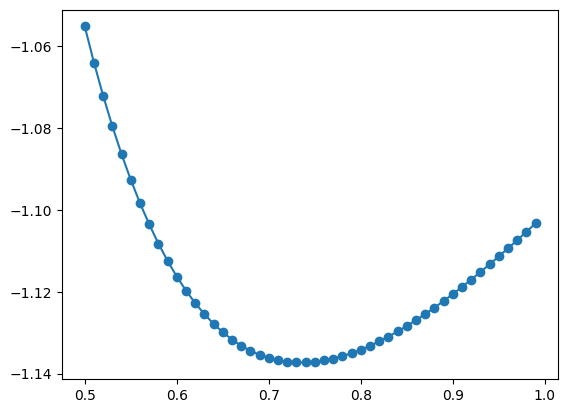

In [12]:
import matplotlib.pyplot as plt

plt.scatter(distances[:], energies[:])
plt.plot(distances[:], energies[:])

minimo = np.min(energies)

In [13]:
np.where(energies == minimo)

d_min = distances[23]

print(d_min)

(array([23]),)

## Practica inicial

Durante esta parte intentaré llegar a una solución mas precisa que la anterior a modo de ir practicando las funciones y conocer mejor las librerias.

Al resultado anterior d_min = 0.7300000000000002 la haré variar en un $\pm 0,01$

In [15]:
# primero estableceré las distancia que utilizaré

distancias = np.arange(0.72, 0.74, 0.001) # la separaciòn entre las distancias serà de 0.001

# ahora definiré las energias, pero como aún no conozco su valor las setearé todas en 0
energias = np.zeros(len(distancias))

#ahora resolveré el problema de optimización para cada distancia

for i, d in enumerate(distancias): # lo que hace esto es que por cada valor de la distancia 'd' le asocia el número i
    #primero debemos crear el problema
    driver = PySCFDriver(atom= f'H 0 0 0 ; H 0 0 {d}') # esto génera la molecula y el atributo atom funiona de la siguiente manera: atom = 'name', x, y, z
    problema = driver.run() # lo iniciamos 
    fermionic_op = problema.hamiltonian.second_q_op() #Acá pasamos el hamiltoniano del problema a la segunda cuantiazión, es decir, en la forma de op de creación y aniquilación

    # Ahora debemos mappear de forma que sea legible para algorithmos cuanticos
    mapper = JordanWignerMapper() # definimos nuestro mapeo, en este caso el de Jordan Wigner

    sparse_pauli_ham = mapper.map(fermionic_op) # le aplicamos el mapeo a nuestra segunda cuantización del problema

    init_state = HartreeFock(num_spatial_orbitals= problema.num_spatial_orbitals,
            num_particles= problema.num_particles,
            qubit_mapper= mapper)  # Acá utilizamos el estado inicial basado en el metodo de Hartree Fock
    
    # Ahora vamos a definir nuestro ansatz el cual está basado en el modelo nitary Coupled Cluster with Single and Double Excitations
    #La clase UCCSD recibe parametros de la siguiente manera: UCCSD(num_exitaciones, num_particlas, mapeo, estado inicial)
    
    ansatz = UCCSD(2,
                   problema.num_particles,
                   mapper,
                   initial_state=HartreeFock(problema.num_spatial_orbitals,
                                             problema.num_particles,
                                             mapper))
    
    # Ahora definimos el algoritmo que vamos a utilizar, es estè caso usaremos el Variational Quantum Eingensolver
    # Este algoritmo busca el valor propio minimo o en otras palabras, el valor minimo de energia
    # Estimator es una clase que se encarga de calcular el valor esperado del hamiltoniano
    # en términos practicos, Estimator evalua como se comporta el hamiltoniano mapeado y entrega valores necesarios para la optimización
    # SLSQP se refiere a Sequential Least Squares Quadratic Programming. Es un optimizador que ajusta los parámetros del ansatz de forma iterativa, buscando la configuración que minimiza la energía esperada.
    vqe = VQE(Estimator(), ansatz, SLSQP())

    # Ahora vamos a definir un puntpo inicial
    initial_point = HFInitialPoint() # Clase que define el punto inicial
    initial_point.ansatz = ansatz # El punto inicial debe ir acorde con el ansatz
    initial_point.problem = problema # Tambien debe ir a corde con el problema, recordar que en problema hay informacion acerca del hamiltoniano
    vqe.initial_point = initial_point.to_numpy_array() #seteamos el punto inicial del VQE como el punto incial que definimos anteriormente 

    # ahora si que si resolvemos el problema 
    # La clase GroundStateEigensolver es una clase que encapsula el proceso de encontrar el valor minimo de energia, recibe el mapeo y el VQE el cual contiene info sobre el anstaz y el punto inicial
    solver = GroundStateEigensolver(mapper, vqe) 
    result = solver.solve(problema) # resolvemos

    energias[i] = result.total_energies[0] #reemplazamos los valores de energìa en nuestra lista del principio


(array([15]),)

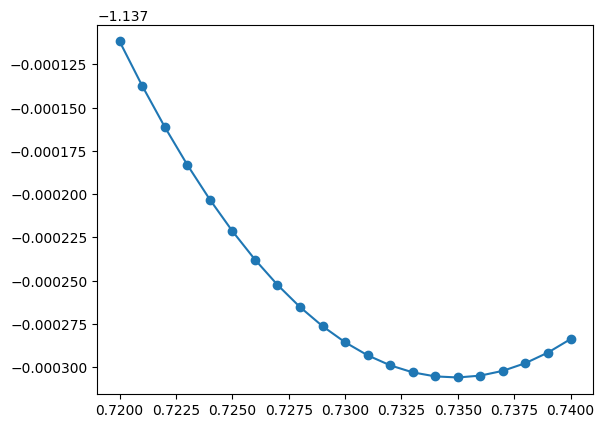

In [16]:
plt.scatter(distancias[:], energias[:])
plt.plot(distancias[:], energias[:])

minimo = np.min(energias)
np.where(energias == minimo)

In [17]:
d_min = distancias[15]

print(d_min)
print('epico')

0.735
epico


## Parte 2: Litio - Hidrogeno

En está parte intentaré descrubir como hacer la simulacion de la molecula Litio-Hidrogeno. En primer lugar replicaré un procedimiento similar al anterior e intentaré descrubir sobre la marcha como solucionar los problemas


In [18]:

distancias = np.arange(0.25, 4, 0.25)

energias = np.zeros(len(distancias))

for i, d in enumerate(distancias): 
    
    driver = PySCFDriver(atom= f'Li 0 0 0 ; H 0 0 {d}')
    problema = driver.run()
    fermionic_op = problema.hamiltonian.second_q_op()
    mapper = JordanWignerMapper()

    sparse_pauli_ham = mapper.map(fermionic_op)

    init_state = HartreeFock(num_spatial_orbitals= problema.num_spatial_orbitals,
            num_particles= problema.num_particles,
            qubit_mapper= mapper) 
    ansatz = UCCSD(2,
                   problema.num_particles,
                   mapper,
                   initial_state=HartreeFock(problema.num_spatial_orbitals,
                                             problema.num_particles,
                                             mapper))
    
    vqe = VQE(Estimator(), ansatz, SLSQP())

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problema
    #vqe.initial_point = initial_point.to_numpy_array()
    #solver = GroundStateEigensolver(mapper, vqe) 
    #result = solver.solve(problema)

    #energias[i] = result.total_energies[0] 


El primer problema que me encontre fue un error en definir el punto inicial. Realmente no se que es lo que falló pero analizando el codigo lo único que pudo haber fallado es el ansatz, enotnces empezaré por intentar solucionar eso

EL codigo que viene a combinaciòn fue el resultado de muchos errores y de descubrir que en el repositorio de Herbert estaba este mismo ejercicio ya hecho

[1.5]


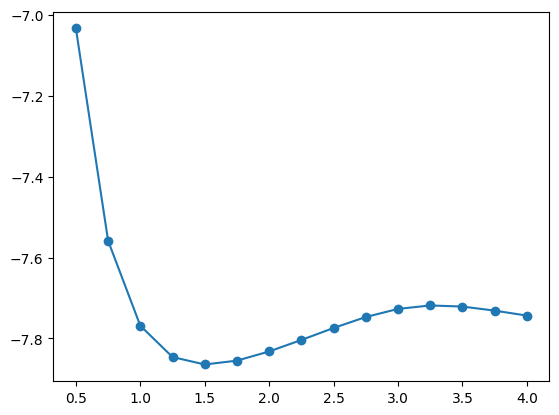

In [19]:

from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import ParityMapper

distancias = np.arange(0.5, 4.25, 0.25)
energias = np.zeros(len(distancias))

for i, d in enumerate(distancias): 
    
    # sto-3g es un tipo de base que usa 3 funciones gaussianas, entre mas  funciones gaussianas, mas preciso pero mas lento
    driver = PySCFDriver(atom= f'Li 0 0 0; H 0 0 {d}', basis="sto-3g") 
    problema = driver.run()

    # FreezeCoreTransforme es una simplificación en donde se consideran que algunos orbitales estan congelados o inactivos
    # En este caso se considera que los obitales 4 y 5 estan no activos
    fc_transformer = FreezeCoreTransformer(remove_orbitals=[4, 5])

    problem = fc_transformer.transform(problema) #aplicamos la congelación al problema

        #Acà aplicamos otro mapeo distinto al de Jordan-winger, sin embargo tambien tiene como objetivo pasar de fermiones a qubit
    mapper = ParityMapper(num_particles= (problem.num_alpha, problem.num_beta))


        # Acà sigue todo igual
    ansatz = UCCSD(problem.num_spatial_orbitals,
                   problem.num_particles,
                   mapper,
                   initial_state=HartreeFock(
                       problem.num_spatial_orbitals,
                       problem.num_particles,
                       mapper,),
    )
    vqe = VQE(Estimator(), ansatz, SLSQP())

    initial_point = HFInitialPoint()
    initial_point.ansatz = ansatz
    initial_point.problem = problem
    vqe.initial_point = initial_point.to_numpy_array()
    solver = GroundStateEigensolver(mapper, vqe) 
    result = solver.solve(problem)

    energias[i] = result.total_energies[0] 

plt.scatter(distancias[:], energias[:])
plt.plot(distancias[:], energias[:])

minimo = np.min(energias)
numero = np.where(energias == minimo)
d_min = distancias[numero]
print(d_min)


## Reaciones de isomerización

Durante la siguiente secciòn intentarè abordar el tema de las reacciones de isomerización, para esto intentaré simular la molecula $C_4H_8$.


In [22]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit import  QuantumCircuit, transpile
import numpy as np
import matplotlib.pyplot as plt
from pycsf

# Definir las distancias para el isómero
distancias = np.arange(0.5, 4.25, 0.25)
energias = np.zeros(len(distancias))
# Z-matrix for 2-butene (C4H8)

zmat = """
C
C 1 1.34
H 2 1.09 1 120.0
H 2 1.09 1 120.0 3 180.0
H 1 1.09 2 120.0
H 1 1.09 2 120.0 4 180.0
"""

# Print the Z-matrix
print(zmat)


for i, d in enumerate(distancias): 
    
    # Definir la molécula de 2-buteno cis/trans
    
    
    driver = PySCFDriver(atom=zmat, basis="sto-3g")  # Nota: esto es un ejemplo simplificado
    problema = driver.run()
    
    # Aplicar transformación FreezeCore si es necesario
    fc_transformer = FreezeCoreTransformer()
    problema = fc_transformer.transform(problema)
    
    # Mapeo de los operadores a qubits
    mapper = JordanWignerMapper()
    sparse_pauli_ham = mapper.map(problema.hamiltonian.second_q_op())
    
    # Definir el ansatz UCCSD
    ansatz = UCCSD(
        num_spatial_orbitals=problema.num_spatial_orbitals,
        num_particles=problema.num_particles,
        qubit_mapper=mapper
    )
    
    # Configurar el VQE
    vqe = VQE(ansatz, optimizer=SLSQP())
    
    # Resolver el problema
    solver = GroundStateEigensolver(mapper, vqe)
    result = solver.solve(problema)
    
    # Almacenar la energía total
    energias[i] = result.total_energies[0] 

# Graficar los resultados
plt.scatter(distancias, energias)
plt.plot(distancias, energias)
plt.xlabel('Distancia (Å)')
plt.ylabel('Energía (Hartree)')
plt.title('Energía del 2-Buteno en función de la distancia')
plt.show()



C
C 1 1.34
H 2 1.09 1 120.0
H 2 1.09 1 120.0 3 180.0
H 1 1.09 2 120.0
H 1 1.09 2 120.0 4 180.0



QiskitNatureError: 'Failed to convert atom string: ;C;C 1 1.34;H 2 1.09 1 120.0;H 2 1.09 1 120.0 3 180.0;H 1 1.09 2 120.0;H 1 1.09 2 120.0 4 180.0;'